<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/machine%20translation/Neural_Machine_Translation_with_Bahdanau_Attention_and_Pretrained_Glove_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals
from builtins import range, input

%tensorflow_version 2.x
import tensorflow as tf
import urllib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(12,10)})

from sklearn.model_selection import train_test_split

import re
import os
import io
import sys
import glob
import time
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import unicodedata

import gc
gc.enable()

import warnings 
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

TensorFlow 2.x selected.


In [0]:
# Can use either of two dataset. To benchmark and check performance of Neural Machine Translation from seq to seq and Neural Machine Translation using Attention Mechanism we're going to use the same dataset.
# Download the dataset from  https://www.manythings.org/anki/
# [OPTIONAL] if youre using google colab.

# try:
#   print('Uploading file...')
#   from google.colab import files
#   files.upload()
#   print("File uploaded sucessfully.")
# except Exception as ex:
#   print(f"Process terminated with exception: {ex}")

In [3]:
## This is another dataset for Neural Machine Translation hosted by google. Either of the dataset can work. 

path_to_zip = tf.keras.utils.get_file('spa-eng.zip',origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',extract=True)
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,])",r" \1 ",w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Z?.!,]+"," ", w)

  w = w.rstrip().strip()
  w = "<start> " + w + " <end>"
  return w

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> may i borrow this book ? <end>
<start> puedo tomar prestado este libro ? <end>


In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split("\n")
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  return zip(*word_pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(f"{en[-1]}")
print(f"{sp[-1]}")

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
print(len(en))
print(len(sp))

118964
118964


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer 

def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, target_lang_tokenizer = tokenize(targ_lang)
  cache = {"input_tensor":input_tensor, "target_tensor":target_tensor, "inp_lang_tokenizer":inp_lang_tokenizer, "target_lang_tokenizer":target_lang_tokenizer}
  return cache

In [0]:
num_examples = 40000
cache = load_dataset(path_to_file, num_examples)
input_tensor, target_tensor, inp_lang, targ_lang = cache["input_tensor"], cache["target_tensor"], cache["inp_lang_tokenizer"], cache["target_lang_tokenizer"]
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val),len(target_tensor_val))

32000 32000 8000 8000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d -----> %s"%(t, lang.index_word[t]))

In [14]:
print(f"Input language; index to word mapping: {convert(inp_lang,input_tensor_train[0])}")
print()
print(f"Target language; index to word mapping: {convert(targ_lang,target_tensor_train[0])}")

1 -----> <start>
22 -----> te
130 -----> gustan
30 -----> los
9843 -----> cappelletis
4 -----> ?
2 -----> <end>
Input language; index to word mapping: None

1 -----> <start>
19 -----> do
5 -----> you
34 -----> like
5225 -----> tortellini
6 -----> ?
2 -----> <end>
Target language; index to word mapping: None


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 100
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).cache().shuffle(BUFFER_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

In [17]:
import urllib
print('Downloading pretrained embedding vectors..')
urllib.request.urlretrieve("https://github.com/allenai/spv2/blob/master/model/glove.6B.100d.txt.gz?raw=true",filename="glove.6B.100d.txt.gz")

print('Extracting pretrained embedding vectors...')
import gzip
import shutil
with gzip.open('glove.6B.100d.txt.gz', 'rb') as f_in:
    with open('glove.6B.100d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('Loading pretrained embedding...')
word2vec = {}
with open('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
print('Filling pretrained embeddings...')
num_words = min(MAX_NUM_WORDS, len(inp_lang.word_index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in inp_lang.word_index.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = inp_lang.word_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      
print('Done.!')

embedding_layer = tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length_inp)

Extracting pretrained embedding vectors...
Loading pretrained embedding...
Found 400000 word vectors
Filling pretrained embeddings...
Done.!


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = embedding 
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_size=vocab_inp_size, embedding=embedding_layer, enc_units=units, batch_sz=BATCH_SIZE)

In [0]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [21]:
print(f"Encoder output shape: (batch_size, sequence_length, units) {sample_output.shape}")
print(f"Encoder hidden state shape: (batch_size, units) {sample_hidden.shape}")

Encoder output shape: (batch_size, sequence_length, units) (64, 16, 1024)
Encoder hidden state shape: (batch_size, units) (64, 1024)


### Bahdanau Attention

![bahdanau attention](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

The input is put through an encoder model which gives us the encoder output of shape (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size).

Here are the equations that are implemented:

![bahdanau attention equations](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)
![bahdanau attention equation final](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)

This tutorial uses Bahdanau attention for the encoder. Let's decide on notation before writing the simplified form:

    FC = Fully connected (dense) layer
    EO = Encoder output
    H = hidden state
    X = input to the decoder


And the pseudo-code:

1. `score = FC(tanh(FC(EO) + FC(H)))`

2. `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.

3. `context vector = sum(attention weights * EO, axis = 1).` Same reason as above for choosing axis as 1.

4. `embedding output` = The input to the decoder X is passed through an embedding layer.

5. `merged vector = concat(embedding output, context vector)`

6. This merged vector is then given to the GRU



In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(values)+self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch_size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch_size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)
  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector,1), x],axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    
    # output shape == (batch_size, vocab)
    x = self.fc(output)

    # output shape == (batch_size, vocab)
    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_deocoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab_size) {}'.format(sample_deocoder_output.shape))

Decoder output shape: (batch_size, vocab_size) (64, 5934)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.0231
Epoch 1 Batch 100 Loss 1.0819
Epoch 1 Batch 200 Loss 1.1089
Epoch 1 Batch 300 Loss 1.1668
Epoch 1 Batch 400 Loss 1.0898
Epoch 1 Loss 1.0941
Time taken for 1 epoch 41.651288986206055 sec

Epoch 2 Batch 0 Loss 1.0348
Epoch 2 Batch 100 Loss 1.1341
Epoch 2 Batch 200 Loss 1.0629
Epoch 2 Batch 300 Loss 1.0150
Epoch 2 Batch 400 Loss 1.0980
Epoch 2 Loss 1.0678
Time taken for 1 epoch 42.48200249671936 sec

Epoch 3 Batch 0 Loss 1.0137
Epoch 3 Batch 100 Loss 1.0105
Epoch 3 Batch 200 Loss 1.0250
Epoch 3 Batch 300 Loss 1.0532
Epoch 3 Batch 400 Loss 1.0195
Epoch 3 Loss 1.0372
Time taken for 1 epoch 42.740365743637085 sec

Epoch 4 Batch 0 Loss 0.9302
Epoch 4 Batch 100 Loss 0.9707
Epoch 4 Batch 200 Loss 0.9482
Epoch 4 Batch 300 Loss 1.0387
Epoch 4 Batch 400 Loss 0.9938
Epoch 4 Loss 1.0103
Time taken for 1 epoch 42.59909772872925 sec

Epoch 5 Batch 0 Loss 1.0110
Epoch 5 Batch 100 Loss 0.9103
Epoch 5 Batch 200 Loss 1.0018
Epoch 5 Batch 300 Loss 1.0167
Epoch 5 Batch 400 Loss 0

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hola , como estas <end>
Predicted translation: you re very well . <end> 


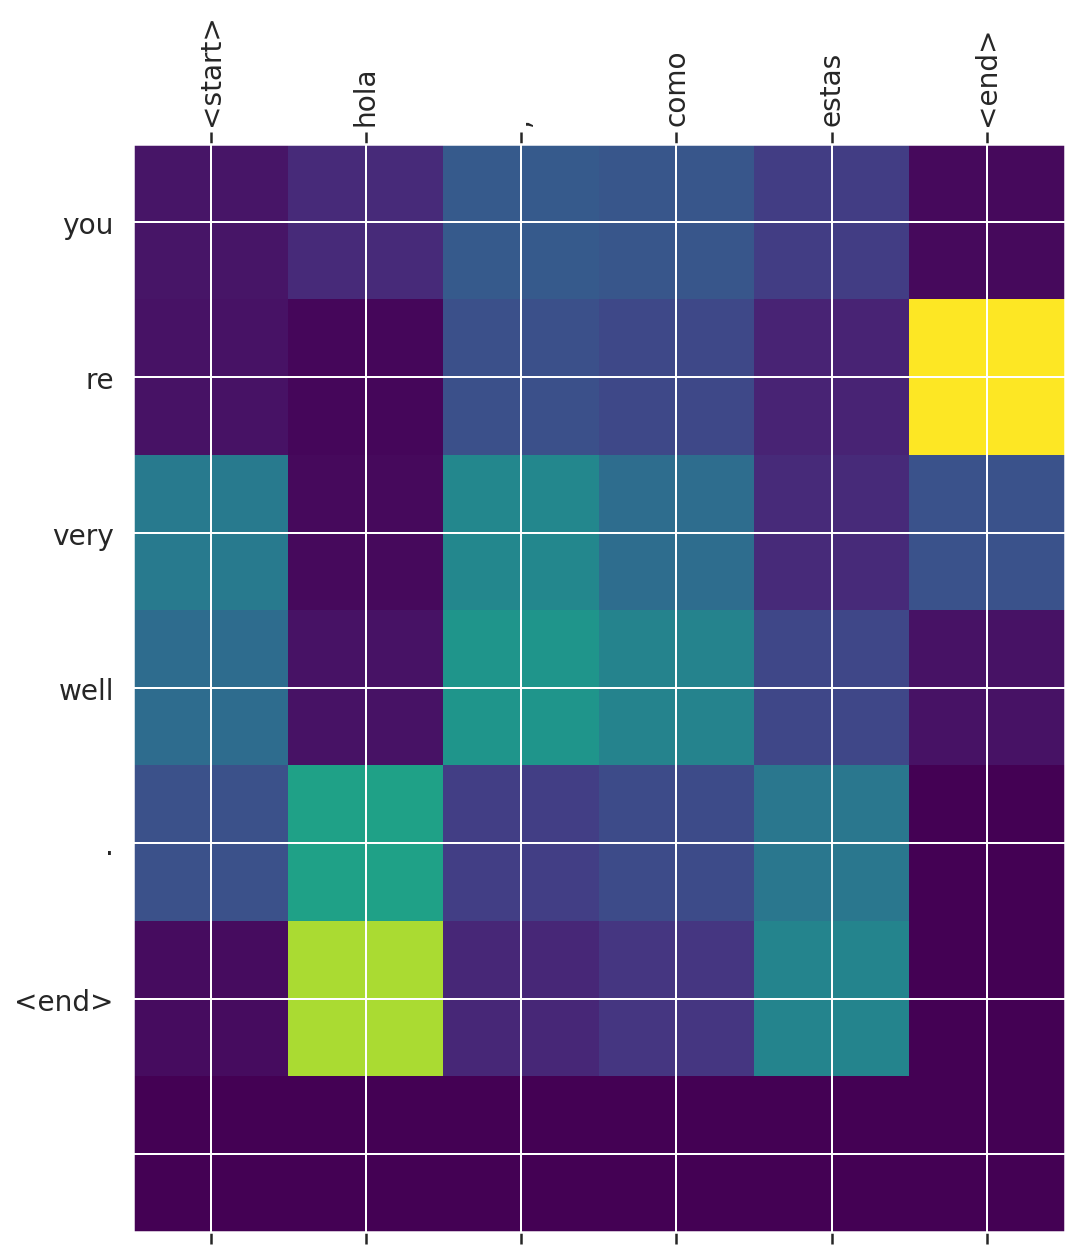

In [43]:
translate(u'Hola, como estas')

Input: <start> hace mucho frio aqui . <end>
Predicted translation: i m here . <end> 


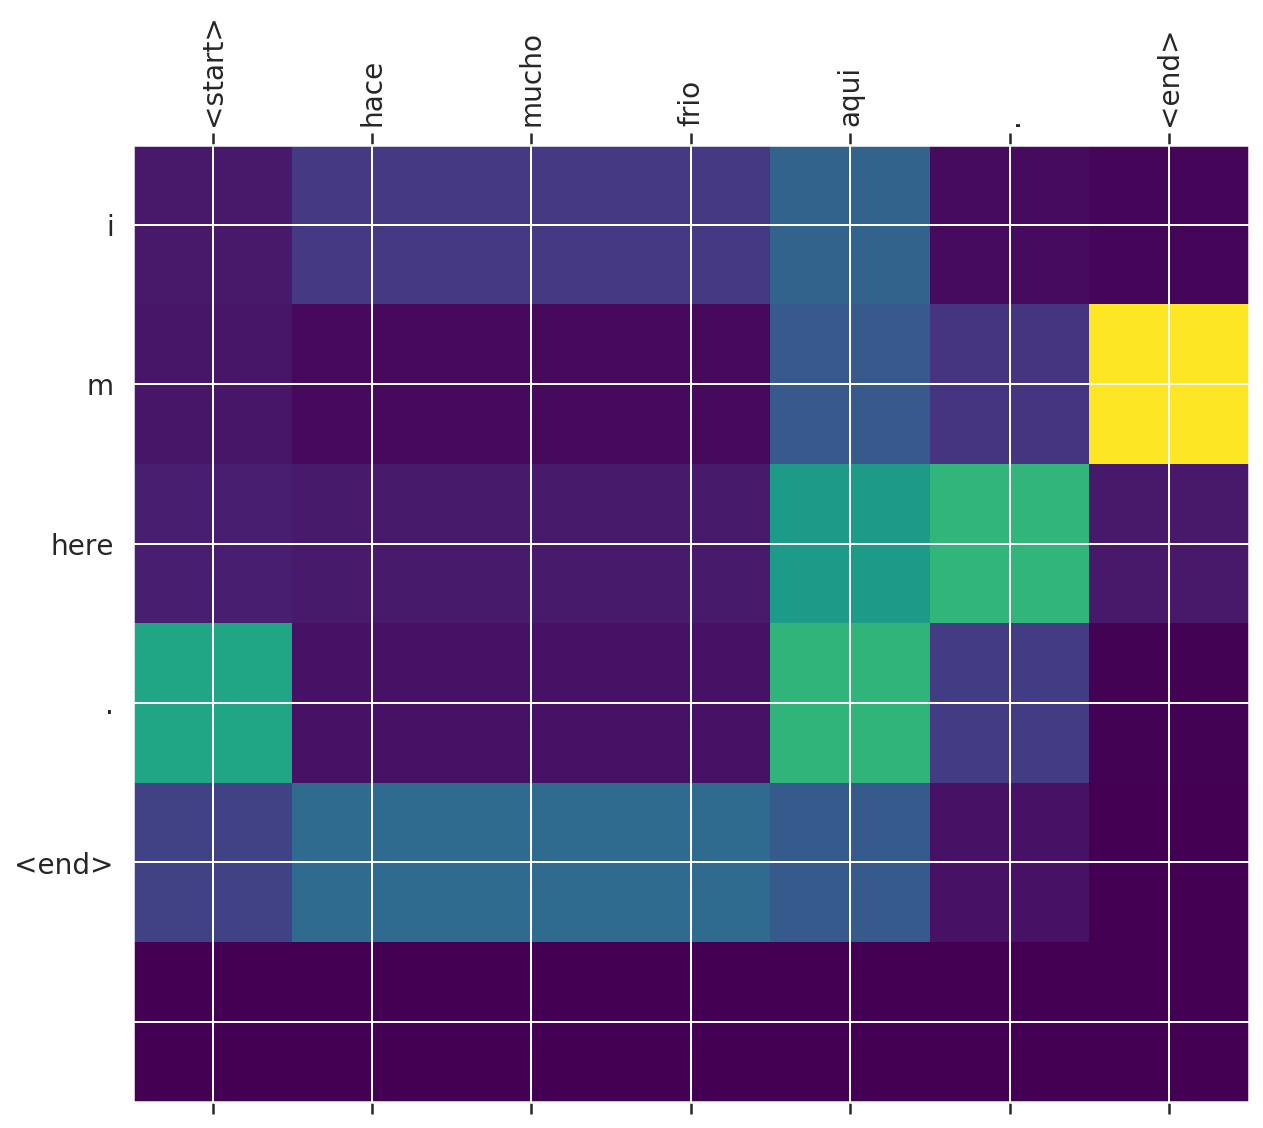

In [44]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: it s my favorite . <end> 


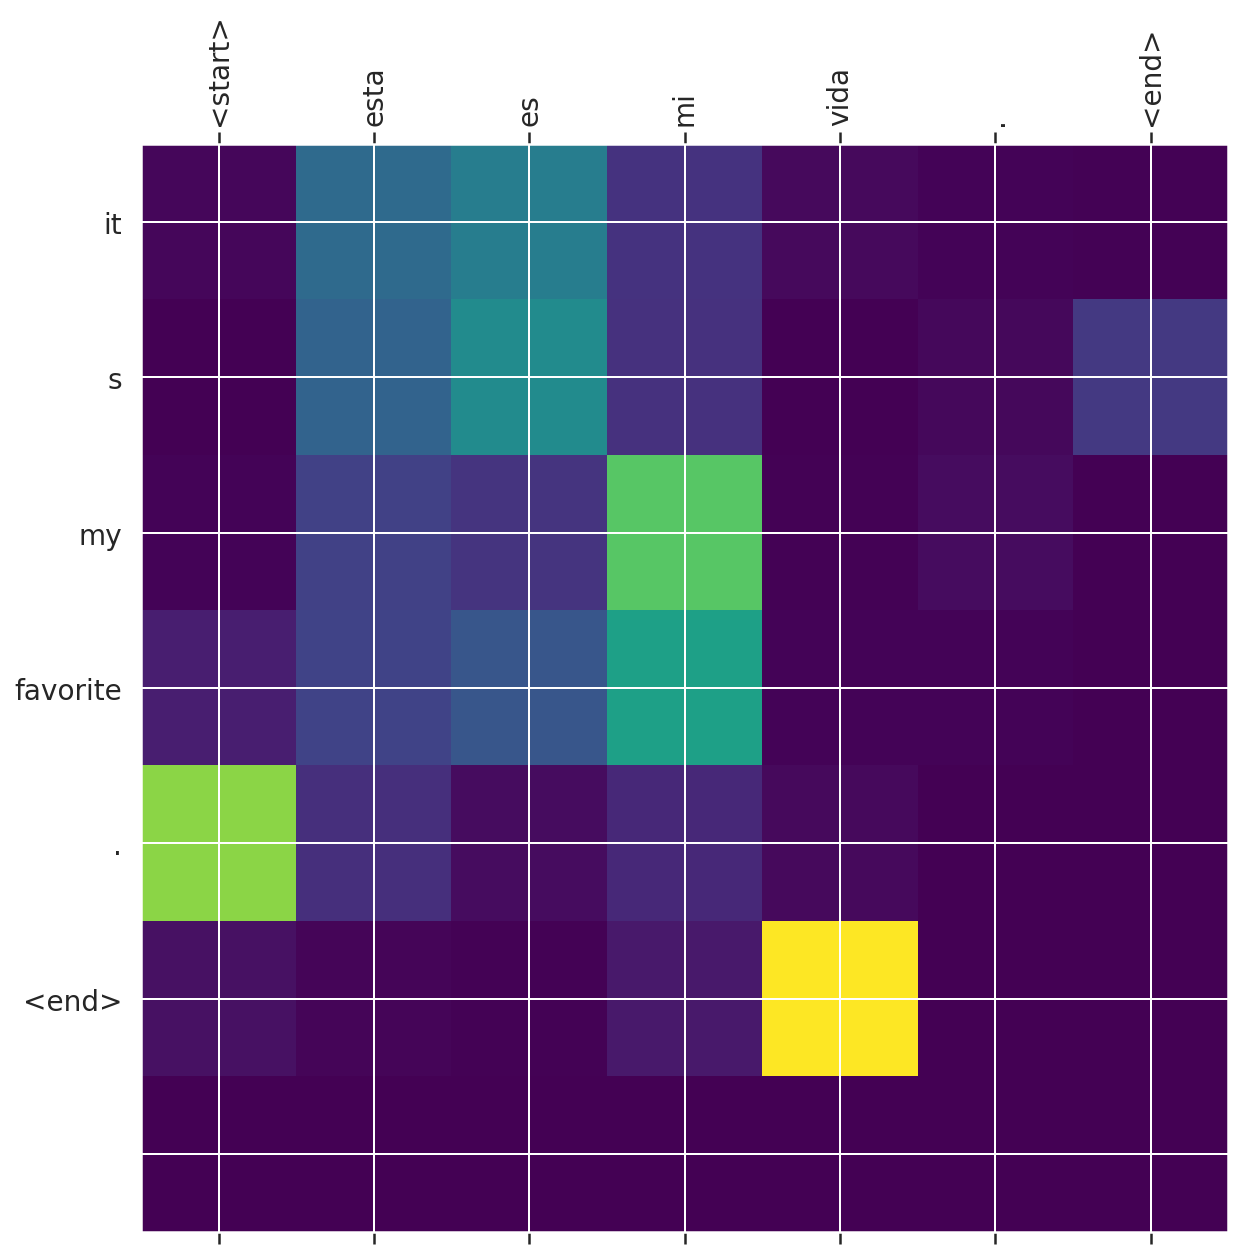

In [45]:
translate(u'esta es mi vida.')